In [ ]:
!pip install pandas numpy json csv

# Limpieza de datos

In [ ]:
import pandas as pd, numpy as np, json, io

# =========================
# Config
# =========================
path = "/content/keplerobjectsofinterest.csv"  # <-- ajusta si es necesario
output_csv  = "kepler_clean.csv"
output_meta = "kepler_clean.meta.json"

BASE_COLS = [
    "koi_period","koi_duration","koi_depth","koi_steff","koi_kepmag",
    "koi_prad","koi_slogg","koi_srad","koi_teq",
]
EXTRA_COLS = ["koi_model_snr","koi_impact","koi_fpflag_nt","koi_fpflag_ss","koi_fpflag_co","koi_fpflag_ec"]
ID_COLS    = ["kepoi_name","kepler_name","koi_name","kepid"]

PHYS_RANGES = {
    "koi_period": (0, None),
    "koi_duration": (0, None),
    "koi_depth": (0, None),
    "koi_steff": (2500, 8000),
    "koi_slogg": (3.0, 5.5),
    "koi_srad": (0.1, 10),
    "koi_kepmag": (8, 18),
}

# =========================
# Helpers
# =========================
def read_bytes(p):
    with open(p, "rb") as f:
        return f.read()

def try_decodings(raw, encodings=("utf-8-sig","utf-8","utf-16","utf-16le","utf-16be","latin-1")):
    for enc in encodings:
        try:
            return raw.decode(enc, errors="replace"), enc
        except Exception:
            pass
    return None, None

def looks_like_header(line_lower: str) -> bool:
    keys = ("koi_disposition","kepoi_name","koi_period")
    many_delims = (line_lower.count(",") >= 10) or (line_lower.count("\t") >= 10) or (line_lower.count(";") >= 10)
    has_key = any(k in line_lower for k in keys) or ("koi_" in line_lower)
    return has_key and many_delims

def find_header_idx(text: str, max_scan: int = 300) -> int:
    lines = text.splitlines()
    # 1) intenta por palabras clave
    for i, line in enumerate(lines[:max_scan]):
        if looks_like_header(line.lower()):
            return i
    # 2) fallback: primera línea con muchas comas y 'koi_'
    for i, line in enumerate(lines[:max_scan]):
        l = line.lower()
        if ("koi_" in l) and (l.count(",") >= 10):
            return i
    # 3) si no, asume 0 (no ideal, pero evita crashear)
    return 0

def build_object_id(df):
    candidates = []
    for c in ["kepoi_name","kepler_name","koi_name"]:
        if c in df.columns:
            candidates.append(df[c].astype(str).str.strip().replace({"": np.nan, "nan": np.nan}))
    if candidates:
        obj = pd.concat(candidates, axis=1).bfill(axis=1).iloc[:,0]
    else:
        obj = pd.Series([np.nan]*len(df), index=df.index, dtype="object")

    if "kepid" in df.columns:
        def to_kic(x):
            try:
                return f"KIC {int(float(x))}"
            except:
                return np.nan
        obj = obj.fillna(df["kepid"].map(to_kic))

    obj = obj.fillna(pd.Series([f"KOI_ROW_{i:06d}" for i in range(len(df))], index=df.index))
    return obj.astype(str)

# =========================
# 1) Leer texto y recortar preámbulo
# =========================
raw = read_bytes(path)
text, used_enc = try_decodings(raw)
if text is None:
    raise RuntimeError("No se pudo decodificar el archivo. Abre en Excel/Sheets y 'Descargar como CSV'.")

header_idx = find_header_idx(text)
lines = text.splitlines()
body = "\n".join(lines[header_idx:])

# =========================
# 2) Parsear CSV desde el header detectado
# =========================
df = None
for sep in [None, ",", "\t", ";", "|"]:
    try:
        kw = dict(engine="python", on_bad_lines="skip")
        if sep is not None:
            kw["sep"] = sep
        tmp = pd.read_csv(io.StringIO(body), **kw)
        # normaliza 'koi_disposition'
        cols_lower = {c.lower(): c for c in tmp.columns}
        if "koi_disposition" in cols_lower:
            if cols_lower["koi_disposition"] != "koi_disposition":
                tmp = tmp.rename(columns={cols_lower["koi_disposition"]: "koi_disposition"})
            df = tmp
            used_sep = "auto" if sep is None else sep
            break
    except Exception:
        continue

if df is None:
    raise RuntimeError("No se pudo parsear la tabla después de recortar el preámbulo. "
                       "Abre el archivo en Excel/Sheets y exporta a CSV plano.")

print(f"Encabezado detectado en línea {header_idx} (encoding={used_enc}, sep={used_sep}) | shape={df.shape}")

# =========================
# 3) Filtro de disposiciones y etiqueta
# =========================
valid_disp = {"CONFIRMED","CANDIDATE","FALSE POSITIVE"}
df["koi_disposition"] = df["koi_disposition"].astype(str).str.upper().str.strip()
df = df[df["koi_disposition"].isin(valid_disp)].copy()
df["label"] = (df["koi_disposition"].isin(["CONFIRMED","CANDIDATE"])).astype(int)

# =========================
# 4) Selección + numérico
# =========================
candidate_cols = BASE_COLS + [c for c in EXTRA_COLS if c in df.columns]
present_cols = [c for c in candidate_cols if c in df.columns]
for c in present_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# =========================
# 5) Imputación (mediana)
# =========================
impute_medians = {c: float(df[c].median()) for c in present_cols}
for c, m in impute_medians.items():
    df[c] = df[c].fillna(m)

# =========================
# 6) Features derivadas
# =========================
if "koi_period" in df.columns:
    df["log_period"] = np.log10(df["koi_period"].clip(lower=1e-6))
if "koi_depth" in df.columns:
    df["log_depth"]  = np.log10(df["koi_depth"].clip(lower=1e-6))
feature_cols = present_cols + [c for c in ["log_period","log_depth"] if c in df.columns]
if "log_period" in df.columns: impute_medians["log_period"] = float(df["log_period"].median())
if "log_depth"  in df.columns: impute_medians["log_depth"]  = float(df["log_depth"].median())

# =========================
# 7) Reglas físicas
# =========================
def keep_range(s, lo=None, hi=None):
    m = pd.Series(True, index=s.index)
    if lo is not None: m &= s >= lo
    if hi is not None: m &= s <= hi
    return m

mask = pd.Series(True, index=df.index)
for col, (lo, hi) in PHYS_RANGES.items():
    if col in df.columns:
        mask &= keep_range(df[col], lo, hi)

df = df[mask].copy().reset_index(drop=True)
df["label"] = df["label"].astype(int)

# =========================
# 8) IDs + fuente
# =========================
id_cols_present = [c for c in ID_COLS if c in df.columns]
df["object_id"] = build_object_id(df)
df["source"] = "KOI"

# =========================
# 9) Exportar
# =========================
meta_cols_out = ["object_id"] + id_cols_present + ["source","koi_disposition"]
output_cols = meta_cols_out + feature_cols + ["label"]
output_cols = [c for c in output_cols if c in df.columns]
df[output_cols].to_csv(output_csv, index=False)

meta = {
    "source": "KOI",
    "encoding_detected": used_enc,
    "header_idx_detected": header_idx,
    "delimiter_used": used_sep,
    "id_columns_present": id_cols_present,
    "feature_columns": feature_cols,
    "label_column": "label",
    "impute_medians": impute_medians,
    "n_rows": int(len(df)),
    "phys_ranges": PHYS_RANGES,
    "meta_columns": meta_cols_out,
}
with open(output_meta, "w") as f:
    json.dump(meta, f, indent=2)

pos_rate = 100.0 * df["label"].mean() if len(df) else 0.0
print("Listo ✅")
print(f"header_idx={header_idx} | encoding={used_enc} | sep={used_sep}")
print(f"Filas limpias: {len(df)} | % positivos: {pos_rate:.2f}%")
print("CSV:", output_csv, "| META:", output_meta)
print("IDs ejemplo:", df["object_id"].head(5).tolist())
print("Features finales:", feature_cols)
print("NaNs por feature:", {c:int(df[c].isna().sum()) for c in feature_cols if c in df.columns})


Encabezado detectado en línea 53 (encoding=utf-8-sig, sep=auto) | shape=(9564, 49)
Listo ✅
header_idx=53 | encoding=utf-8-sig | sep=auto
Filas limpias: 9220 | % positivos: 50.78%
CSV: kepler_clean.csv | META: kepler_clean.meta.json
IDs ejemplo: ['K00752.01', 'K00752.02', 'K00753.01', 'K00754.01', 'K00755.01']
Features finales: ['koi_period', 'koi_duration', 'koi_depth', 'koi_steff', 'koi_kepmag', 'koi_prad', 'koi_slogg', 'koi_srad', 'koi_teq', 'koi_model_snr', 'koi_impact', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'log_period', 'log_depth']
NaNs por feature: {'koi_period': 0, 'koi_duration': 0, 'koi_depth': 0, 'koi_steff': 0, 'koi_kepmag': 0, 'koi_prad': 0, 'koi_slogg': 0, 'koi_srad': 0, 'koi_teq': 0, 'koi_model_snr': 0, 'koi_impact': 0, 'koi_fpflag_nt': 0, 'koi_fpflag_ss': 0, 'koi_fpflag_co': 0, 'koi_fpflag_ec': 0, 'log_period': 0, 'log_depth': 0}


# Entrenamiento del modelo

In [1]:
# =======================
# KOI tabular → RF → métricas + CSV de predicciones + modelo
# =======================
import pandas as pd, numpy as np, json
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,
    accuracy_score, matthews_corrcoef, confusion_matrix
)
from joblib import dump

# -------- CONFIG ----------
CSV_IN = "/content/kepler_clean.csv"   # <-- cambia si es necesario
OUT_DIR = Path("/content")             # carpeta de salida
TEST_SIZE = 0.30                       # 0.30 = 70/30 (pon 0.20 para 80/20)
RANDOM_STATE = 42
USE_FPFLAGS = False                    # True para incluir koi_fpflag_*, False para excluir (recomendado)
GOAL_RECALL = 0.95                     # si recall >= GOAL y AUC >= GOAL_AUC: no se ajusta nada
GOAL_AUC    = 0.98
AUTO_TUNE_THRESHOLD_IF_BELOW_GOAL = True

# -------- CARGA ----------
df = pd.read_csv(CSV_IN)
assert "label" in df.columns, "No encuentro la columna 'label' en el CSV."

# Metas para exportar
meta_cols = [c for c in ["object_id","kepoi_name","kepler_name","kepid","source","koi_disposition"] if c in df.columns]

# Features numéricas
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in num_cols if c != "label"]
if not USE_FPFLAGS:
    feature_cols = [c for c in feature_cols if not c.startswith("koi_fpflag_")]

X = df[feature_cols].copy()
y = df["label"].astype(int)

print(f"Filas: {len(df)} | Features: {len(feature_cols)} | %Positivos: {100*y.mean():.2f}%")
print("Ejemplo de features:", feature_cols[:10])

# -------- SPLIT 70/30 ESTRATIFICADO ----------
X_tr, X_te, y_tr, y_te, idx_tr, idx_te = train_test_split(
    X, y, np.arange(len(df)), test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# -------- MODELO (RF estable) ----------
rf = RandomForestClassifier(
    n_estimators=500, max_depth=12, min_samples_leaf=5,
    max_features="sqrt", random_state=RANDOM_STATE, n_jobs=-1
)
rf.fit(X_tr, y_tr)

# -------- MÉTRICAS (umbral 0.50) ----------
proba_te = rf.predict_proba(X_te)[:, 1]
thr_default = 0.50
pred_te_050 = (proba_te >= thr_default).astype(int)

metrics_050 = {
    "AUC": roc_auc_score(y_te, proba_te),
    "Accuracy": accuracy_score(y_te, pred_te_050),
    "F1": f1_score(y_te, pred_te_050),
    "Precision": precision_score(y_te, pred_te_050),
    "Recall": recall_score(y_te, pred_te_050),
    "MCC": matthews_corrcoef(y_te, pred_te_050),
}
cm_050 = confusion_matrix(y_te, pred_te_050).tolist()

print("\n=== TEST @thr=0.50 ===")
for k,v in metrics_050.items():
    print(f"{k}: {v:.4f}")
print("Confusion matrix [[TN FP],[FN TP]]:", cm_050)

# -------- CV 5-fold para estabilidad ----------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
# out-of-fold probabilities en TODO el conjunto (para elegir umbral sin mirar al test)
oof_proba = cross_val_predict(
    rf, X, y, cv=cv, method="predict_proba", n_jobs=-1
)[:, 1]

def best_threshold(y_true, proba, goal_recall=None):
    """Devuelve dos umbrales: max F1 y alto recall (>= goal_recall si posible)."""
    ths = np.linspace(0.2, 0.8, 121)
    f1s = []
    recs = []
    for t in ths:
        p = (proba >= t).astype(int)
        recs.append(recall_score(y_true, p))
        f1s.append(f1_score(y_true, p))
    t_f1 = float(ths[int(np.argmax(f1s))])
    if goal_recall is None:
        t_rec = t_f1
    else:
        mask = np.array(recs) >= goal_recall
        if mask.any():
            # entre los que cumplen recall, el de mayor F1
            idx = np.argmax(np.array(f1s)[mask])
            t_rec = float(ths[mask][idx])
        else:
            t_rec = t_f1
    return t_f1, t_rec

t_f1, t_hiR = best_threshold(y, oof_proba, goal_recall=GOAL_RECALL)

# ¿Son buenas las métricas con 0.5?
good_enough = (metrics_050["Recall"] >= GOAL_RECALL) and (metrics_050["AUC"] >= GOAL_AUC)
chosen_thr = thr_default

if (not good_enough) and AUTO_TUNE_THRESHOLD_IF_BELOW_GOAL:
    # re-evaluar en TEST con umbral elegido por CV
    pred_te_f1  = (proba_te >= t_f1 ).astype(int)
    pred_te_hiR = (proba_te >= t_hiR).astype(int)

    f1_f1  = f1_score(y_te, pred_te_f1)
    f1_hiR = f1_score(y_te, pred_te_hiR)
    rec_f1  = recall_score(y_te, pred_te_f1)
    rec_hiR = recall_score(y_te, pred_te_hiR)

    # preferimos alto recall si supera el objetivo; si no, el mejor F1
    if rec_hiR >= GOAL_RECALL and f1_hiR >= f1_f1:
        chosen_thr = t_hiR
    else:
        chosen_thr = t_f1

    print(f"\nUmbral ajustado por CV (si hacía falta): maxF1={t_f1:.2f}, hiRecall={t_hiR:.2f} → elegido={chosen_thr:.2f}")
else:
    print("\nMétricas buenas → se mantiene umbral 0.50 (sin ajustes).")

# -------- MÉTRICAS FINALES EN TEST CON UMBRAL ELEGIDO ----------
pred_te = (proba_te >= chosen_thr).astype(int)
final_metrics = {
    "AUC": roc_auc_score(y_te, proba_te),
    "Accuracy": accuracy_score(y_te, pred_te),
    "F1": f1_score(y_te, pred_te),
    "Precision": precision_score(y_te, pred_te),
    "Recall": recall_score(y_te, pred_te),
    "MCC": matthews_corrcoef(y_te, pred_te),
    "Threshold_used": chosen_thr
}
final_cm = confusion_matrix(y_te, pred_te).tolist()

print("\n=== TEST (final) ===")
for k,v in final_metrics.items():
    if k != "Threshold_used":
        print(f"{k}: {v:.4f}")
print("Threshold_used:", chosen_thr)
print("Confusion matrix [[TN FP],[FN TP]]:", final_cm)

# -------- SALIDAS ----------
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Predicciones de TEST
pred_df = df.loc[idx_te, meta_cols].copy()
pred_df["true_label"] = y_te.values
pred_df["proba_1"]    = proba_te
pred_df["pred_label"] = pred_te
pred_path = OUT_DIR / "predicciones_koi_test.csv"
pred_df.to_csv(pred_path, index=False)

# Importancias
fi = pd.DataFrame({"feature": feature_cols, "importance": rf.feature_importances_}) \
        .sort_values("importance", ascending=False)
fi_path = OUT_DIR / "feature_importances_rf.csv"
fi.to_csv(fi_path, index=False)

# Métricas
metrics_payload = {
    "test_metrics_default_thr_0.50": metrics_050,
    "test_metrics_final": final_metrics,
    "confusion_matrix_final": final_cm,
    "cv_info": {"cv_folds": 5, "oof_threshold_maxF1": t_f1, "oof_threshold_hiRecall": t_hiR},
    "config": {
        "test_size": TEST_SIZE, "random_state": RANDOM_STATE,
        "use_fpflags": USE_FPFLAGS, "goal_recall": GOAL_RECALL, "goal_auc": GOAL_AUC
    }
}
metrics_path = OUT_DIR / "metrics_rf.json"
with open(metrics_path, "w") as f:
    json.dump(metrics_payload, f, indent=2)

# Modelo
model_path = OUT_DIR / "rf_koi.joblib"
dump(rf, model_path)

print("\nGuardado:")
print(" - Predicciones test:", pred_path)
print(" - Importancias:", fi_path)
print(" - Métricas JSON:", metrics_path)
print(" - Modelo:", model_path)

Filas: 9220 | Features: 14 | %Positivos: 50.78%
Ejemplo de features: ['kepid', 'koi_period', 'koi_duration', 'koi_depth', 'koi_steff', 'koi_kepmag', 'koi_prad', 'koi_slogg', 'koi_srad', 'koi_teq']

=== TEST @thr=0.50 ===
AUC: 0.9177
Accuracy: 0.8380
F1: 0.8430
Precision: 0.8302
Recall: 0.8562
MCC: 0.6762
Confusion matrix [[TN FP],[FN TP]]: [[1115, 246], [202, 1203]]

Umbral ajustado por CV (si hacía falta): maxF1=0.47, hiRecall=0.31 → elegido=0.47

=== TEST (final) ===
AUC: 0.9177
Accuracy: 0.8373
F1: 0.8463
Precision: 0.8135
Recall: 0.8819
MCC: 0.6766
Threshold_used: 0.4650000000000001
Confusion matrix [[TN FP],[FN TP]]: [[1077, 284], [166, 1239]]

Guardado:
 - Predicciones test: /content/predicciones_koi_test.csv
 - Importancias: /content/feature_importances_rf.csv
 - Métricas JSON: /content/metrics_rf.json
 - Modelo: /content/rf_koi.joblib


ddsds

In [2]:
# =======================
# ENTREGA DEL MODELO (solo entrenar y guardar)
# =======================
import pandas as pd, numpy as np, json
from pathlib import Path
from joblib import dump
from sklearn.ensemble import RandomForestClassifier

# ---- CONFIG ----
CSV_IN = "/content/kepler_clean.csv"   # <-- tu dataset limpio
OUT_DIR = Path("/content")             # <-- carpeta de salida
RANDOM_STATE = 42
THRESHOLD = 0.46                       # umbral operativo acordado
USE_FPFLAGS = False                    # mantén False para generalizar mejor

OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---- carga + features ----
df = pd.read_csv(CSV_IN)
assert "label" in df.columns, "Falta 'label' en el CSV."

# derivadas por si acaso (mismas que usamos)
if {"koi_period","koi_duration","koi_depth"}.issubset(df.columns):
    with np.errstate(divide="ignore", invalid="ignore"):
        df["duty_cycle"] = df["koi_duration"] / (df["koi_period"] * 24.0)
df["depth_frac"]  = (df["koi_depth"].clip(lower=1e-9)) * 1e-6 if "koi_depth" in df else np.nan
df["rprstar_est"] = np.sqrt(df["depth_frac"]) if "depth_frac" in df else np.nan

ban = {"label","object_id","kepoi_name","kepler_name","koi_name",
       "kepid","source","koi_disposition"}  # no usar como features
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in num_cols if c not in ban]
if not USE_FPFLAGS:
    features = [c for c in features if not c.startswith("koi_fpflag_")]

X = df[features].copy()
y = df["label"].astype(int).values

print(f"Entrenando RF con {len(X)} filas y {len(features)} features...")

# ---- modelo final ----
rf = RandomForestClassifier(
    n_estimators=500, max_depth=12, min_samples_leaf=5,
    max_features="sqrt", random_state=RANDOM_STATE, n_jobs=-1
)
rf.fit(X, y)

# ---- guardar artefactos de entrega ----
dump(rf, OUT_DIR/"rf_koi.joblib")

config = {
    "model_name": "RandomForest KOI",
    "random_state": RANDOM_STATE,
    "threshold": THRESHOLD,
    "features": features,
    "notes": "Sin koi_fpflag_*; IDs excluidos; derivadas duty_cycle/depth_frac/rprstar_est."
}
with open(OUT_DIR/"final_config.json","w") as f:
    json.dump(config, f, indent=2)

print("OK ✅  Guardado:")
print("  -", OUT_DIR/"rf_koi.joblib")
print("  -", OUT_DIR/"final_config.json")


Entrenando RF con 9220 filas y 16 features...
OK ✅  Guardado:
  - /content/rf_koi.joblib
  - /content/final_config.json


Filas=9220 | Features=16 | %Pos=50.78%
Primeras columnas: ['koi_period', 'koi_duration', 'koi_depth', 'koi_steff', 'koi_kepmag', 'koi_prad', 'koi_slogg', 'koi_srad', 'koi_teq', 'koi_model_snr', 'koi_impact', 'log_period']
Split -> Train:5532  Val:1844  Test:1844

=== VALID @thr=0.50 ===
AUC=0.9168 | PR-AUC=0.9194 | Acc=0.8270 | Prec=0.8258 | Recall=0.8355 | F1=0.8306 | MCC=0.6539
CM [[TN FP],[FN TP]]: [[743, 165], [154, 782]]

Umbrales VALID → maxF1=0.43 | hiRecall=0.32  → elegido=0.32


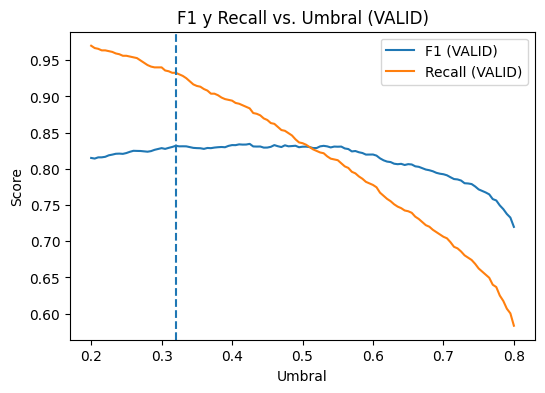


=== VALID (final) @thr=0.32 ===
AUC=0.9168 | PR-AUC=0.9194 | Acc=0.8086 | Prec=0.7506 | Recall=0.9327 | F1=0.8318 | MCC=0.6353
CM [[TN FP],[FN TP]]: [[618, 290], [63, 873]]

=== TEST (final) @thr=0.32 ===
AUC=0.9090 | PR-AUC=0.9040 | Acc=0.7983 | Prec=0.7366 | Recall=0.9380 | F1=0.8252 | MCC=0.6193
CM [[TN FP],[FN TP]]: [[594, 314], [58, 878]]


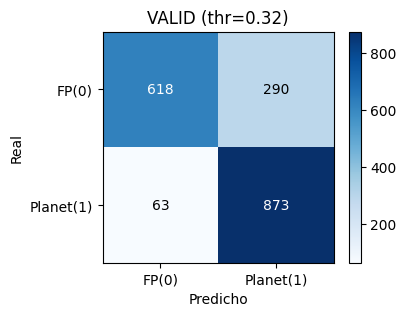

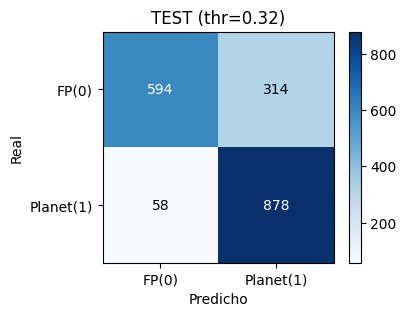

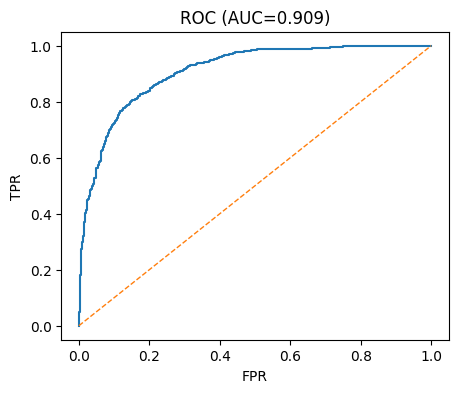

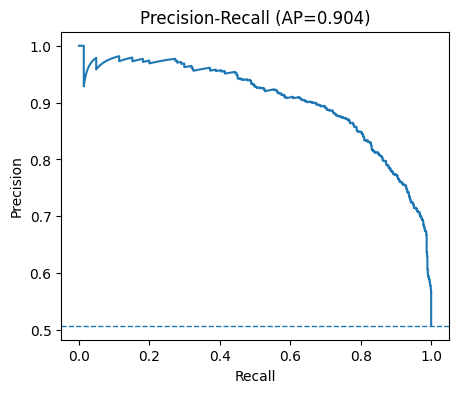

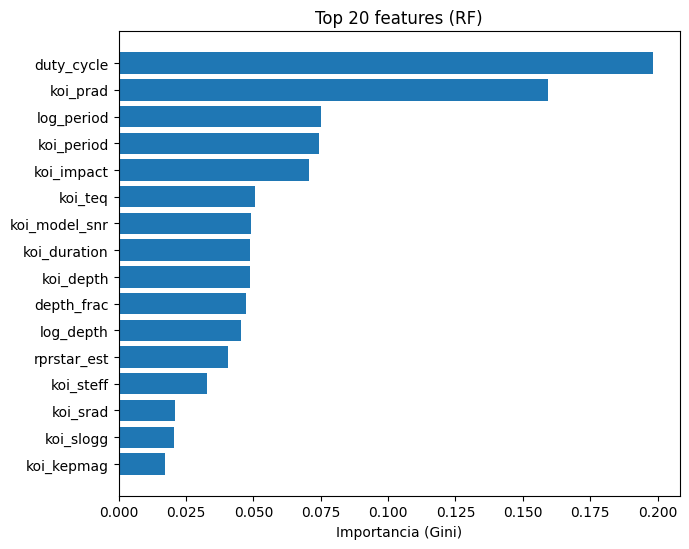

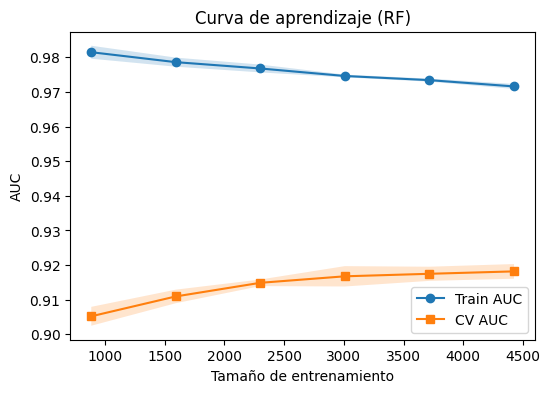


=== CLASSIFICATION REPORTS ===

TRAIN
               precision    recall  f1-score   support

           0       0.94      0.88      0.91      2722
           1       0.89      0.94      0.92      2810

    accuracy                           0.91      5532
   macro avg       0.91      0.91      0.91      5532
weighted avg       0.91      0.91      0.91      5532


VALID (thr=0.32)
               precision    recall  f1-score   support

           0       0.91      0.68      0.78       908
           1       0.75      0.93      0.83       936

    accuracy                           0.81      1844
   macro avg       0.83      0.81      0.80      1844
weighted avg       0.83      0.81      0.81      1844


TEST  (thr=0.32)
               precision    recall  f1-score   support

           0       0.91      0.65      0.76       908
           1       0.74      0.94      0.83       936

    accuracy                           0.80      1844
   macro avg       0.82      0.80      0.79      1

In [3]:
# =======================
# VALIDACIÓN + GRÁFICAS (60/20/20) para el pitch
# =======================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve, confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef)

# ---- CONFIG ----
CSV_IN = "/content/kepler_clean.csv"
RANDOM_STATE = 42
GOAL_RECALL = 0.90     # meta de recall para elegir umbral
USE_FPFLAGS = False

# ---- carga + features (idéntico al bloque A) ----
df = pd.read_csv(CSV_IN)
assert "label" in df.columns, "Falta 'label'."

# derivadas por si acaso
if {"koi_period","koi_duration","koi_depth"}.issubset(df.columns):
    with np.errstate(divide="ignore", invalid="ignore"):
        df["duty_cycle"] = df["koi_duration"] / (df["koi_period"] * 24.0)
df["depth_frac"]  = (df["koi_depth"].clip(lower=1e-9)) * 1e-6 if "koi_depth" in df else np.nan
df["rprstar_est"] = np.sqrt(df["depth_frac"]) if "depth_frac" in df else np.nan

ban = {"label","object_id","kepoi_name","kepler_name","koi_name",
       "kepid","source","koi_disposition"}
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in num_cols if c not in ban]
if not USE_FPFLAGS:
    features = [c for c in features if not c.startswith("koi_fpflag_")]

X = df[features].copy().values
y = df["label"].astype(int).values

print(f"Filas={len(y)} | Features={len(features)} | %Pos={100*y.mean():.2f}%")
print("Primeras columnas:", features[:12])

# ---- SPLIT 60/20/20 (estratificado) ----
X_tmp, X_test, y_tmp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_tmp
)  # 0.25 del 80% -> 20%

print(f"Split -> Train:{len(y_train)}  Val:{len(y_val)}  Test:{len(y_test)}")

# ---- Modelo RF (mismos hiperparámetros) ----
rf = RandomForestClassifier(
    n_estimators=500, max_depth=12, min_samples_leaf=5,
    max_features="sqrt", random_state=RANDOM_STATE, n_jobs=-1
)
rf.fit(X_train, y_train)

# ---- Probabilidades ----
p_val = rf.predict_proba(X_val)[:,1]
p_tst = rf.predict_proba(X_test)[:,1]

# ---- Funciones útiles ----
def metrics_block(y_true, proba, thr, title):
    pred = (proba >= thr).astype(int)
    auc = roc_auc_score(y_true, proba)
    ap  = average_precision_score(y_true, proba)
    acc = accuracy_score(y_true, pred)
    prec= precision_score(y_true, pred)
    rec = recall_score(y_true, pred)
    f1  = f1_score(y_true, pred)
    mcc = matthews_corrcoef(y_true, pred)
    cm  = confusion_matrix(y_true, pred)
    print(f"\n=== {title} @thr={thr:.2f} ===")
    print(f"AUC={auc:.4f} | PR-AUC={ap:.4f} | Acc={acc:.4f} | Prec={prec:.4f} | Recall={rec:.4f} | F1={f1:.4f} | MCC={mcc:.4f}")
    print("CM [[TN FP],[FN TP]]:", cm.tolist())
    return {"AUC":auc,"AP":ap,"Acc":acc,"Prec":prec,"Rec":rec,"F1":f1,"MCC":mcc,"CM":cm}

def plot_confusion(cm, title):
    fig, ax = plt.subplots(figsize=(4,3))
    im = ax.imshow(cm, cmap="Blues")
    ax.figure.colorbar(im, ax=ax)
    ax.set_xticks([0,1]); ax.set_xticklabels(["FP(0)","Planet(1)"])
    ax.set_yticks([0,1]); ax.set_yticklabels(["FP(0)","Planet(1)"])
    ax.set_xlabel("Predicho"); ax.set_ylabel("Real")
    ax.set_title(title)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha="center", va="center",
                    color="white" if cm[i,j] > cm.max()/2 else "black")
    plt.show()

# ---- 1) Métricas @0.50 en VALID ----
m_val_050 = metrics_block(y_val, p_val, 0.50, "VALID")

# ---- 2) Elegir UMBRAL en VALID (max-F1 priorizando recall objetivo) ----
ths = np.linspace(0.20, 0.80, 121)
f1s, recs = [], []
for t in ths:
    yhat = (p_val >= t).astype(int)
    f1s.append(f1_score(y_val, yhat))
    recs.append(recall_score(y_val, yhat))

t_maxF1 = float(ths[int(np.argmax(f1s))])
mask = np.array(recs) >= GOAL_RECALL
if mask.any():
    t_hiR = float(ths[mask][np.argmax(np.array(f1s)[mask])])
else:
    t_hiR = t_maxF1
CHOSEN_THR = t_hiR

print(f"\nUmbrales VALID → maxF1={t_maxF1:.2f} | hiRecall={t_hiR:.2f}  → elegido={CHOSEN_THR:.2f}")

# ---- 3) Curvas de UMBRAL (VALID) ----
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ths, f1s, label="F1 (VALID)")
ax.plot(ths, recs, label="Recall (VALID)")
ax.axvline(CHOSEN_THR, linestyle="--")
ax.set_xlabel("Umbral"); ax.set_ylabel("Score")
ax.set_title("F1 y Recall vs. Umbral (VALID)")
ax.legend(); plt.show()

# ---- 4) Métricas finales en VALID y TEST (umbral elegido) ----
m_val = metrics_block(y_val, p_val, CHOSEN_THR, "VALID (final)")
m_tst = metrics_block(y_test, p_tst, CHOSEN_THR, "TEST (final)")

# ---- 5) Matrices de confusión (gráficas) ----
plot_confusion(m_val["CM"],  f"VALID (thr={CHOSEN_THR:.2f})")
plot_confusion(m_tst["CM"], f"TEST (thr={CHOSEN_THR:.2f})")

# ---- 6) Curvas ROC y PR (TEST) ----
fpr, tpr, _ = roc_curve(y_test, p_tst)
prec, rec, _ = precision_recall_curve(y_test, p_tst)

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(fpr, tpr)
ax.plot([0,1],[0,1],'--',lw=1)
ax.set_xlabel("FPR"); ax.set_ylabel("TPR"); ax.set_title(f"ROC (AUC={m_tst['AUC']:.3f})")
plt.show()

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(rec, prec)
base = (y_test.mean())
ax.axhline(base, linestyle="--", linewidth=1)
ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
ax.set_title(f"Precision-Recall (AP={m_tst['AP']:.3f})")
plt.show()

# ---- 7) Importancia de variables (top 20) ----
rf_full = rf  # ya entrenado
imp = (pd.DataFrame({"feature": features, "importance": rf_full.feature_importances_})
         .sort_values("importance", ascending=False))
top = imp.head(20)
fig, ax = plt.subplots(figsize=(7, max(4, len(top)*0.35)))
ax.barh(range(len(top)), top["importance"].values[::-1])
ax.set_yticks(range(len(top))); ax.set_yticklabels(top["feature"].values[::-1])
ax.set_xlabel("Importancia (Gini)"); ax.set_title("Top 20 features (RF)")
plt.tight_layout(); plt.show()

# ---- 8) Curva de aprendizaje (AUC) ----
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
sizes = np.linspace(0.2, 1.0, 6)
tr_sizes, tr_scores, va_scores = learning_curve(
    rf_full, X_train, y_train, cv=cv, train_sizes=sizes, scoring="roc_auc",
    n_jobs=-1, shuffle=True
)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(tr_sizes, tr_scores.mean(axis=1), marker='o', label='Train AUC')
ax.fill_between(tr_sizes, tr_scores.mean(axis=1)-tr_scores.std(axis=1),
                           tr_scores.mean(axis=1)+tr_scores.std(axis=1), alpha=0.2)
ax.plot(tr_sizes, va_scores.mean(axis=1), marker='s', label='CV AUC')
ax.fill_between(tr_sizes, va_scores.mean(axis=1)-va_scores.std(axis=1),
                           va_scores.mean(axis=1)+va_scores.std(axis=1), alpha=0.2)
ax.set_xlabel("Tamaño de entrenamiento"); ax.set_ylabel("AUC")
ax.set_title("Curva de aprendizaje (RF)")
ax.legend(); plt.show()

# ---- 9) Reportes de clasificación (texto, listo para slide) ----
print("\n=== CLASSIFICATION REPORTS ===")
print("\nTRAIN\n", classification_report(y_train, rf.predict(X_train)))
print("\nVALID (thr={:.2f})\n".format(CHOSEN_THR),
      classification_report(y_val, (p_val >= CHOSEN_THR).astype(int)))
print("\nTEST  (thr={:.2f})\n".format(CHOSEN_THR),
      classification_report(y_test, (p_tst >= CHOSEN_THR).astype(int)))


# Exportar el Modelo

In [6]:
from joblib import dump
import json, numpy as np, pandas as pd
from sklearn.ensemble import RandomForestClassifier

CSV_IN = "/content/kepler_clean.csv"
THRESHOLD = 0.32
RANDOM_STATE = 42
USE_FPFLAGS = False

df = pd.read_csv(CSV_IN)
# derivadas como en validación
if {"koi_period","koi_duration","koi_depth"}.issubset(df.columns):
    with np.errstate(divide="ignore", invalid="ignore"):
        df["duty_cycle"] = df["koi_duration"] / (df["koi_period"] * 24.0)
df["depth_frac"]  = (df["koi_depth"].clip(lower=1e-9))*1e-6 if "koi_depth" in df else np.nan
df["rprstar_est"] = np.sqrt(df["depth_frac"]) if "depth_frac" in df else np.nan

ban = {"label","object_id","kepoi_name","kepler_name","koi_name","kepid","source","koi_disposition"}
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in num_cols if c not in ban]
if not USE_FPFLAGS:
    features = [c for c in features if not c.startswith("koi_fpflag_")]

X = df[features]
y = df["label"].astype(int).values

rf = RandomForestClassifier(
    n_estimators=500, max_depth=12, min_samples_leaf=5,
    max_features="sqrt", random_state=RANDOM_STATE, n_jobs=-1
).fit(X, y)

dump(rf, "rf_koi.joblib")
with open("final_config.json","w") as f:
    json.dump({"threshold": THRESHOLD, "features": features, "random_state": RANDOM_STATE}, f, indent=2)

print("Exportado: rf_koi.joblib + final_config.json")


Exportado: rf_koi.joblib + final_config.json


# Prueba del modelo

Filas=9220 | Features=16 | %Pos=50.8%
Features clave: ['koi_period', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_model_snr', 'koi_impact', 'duty_cycle']
Modelo cargado ✅  | Umbral=0.32


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



=== Métricas TEST (umbral app) ===
ROC_AUC: 0.959
PR_AUC: 0.952
Accuracy: 0.860
Precision: 0.791
Recall: 0.984
F1: 0.877
MCC: 0.741
Confusion matrix [[TN FP],[FN TP]]:
 [[664 244]
 [ 15 921]]

Top 10 candidatos (probabilidad más alta):


,object_id,kepoi_name,kepler_name,kepid,koi_disposition,probability,verdict,true_txt,koi_period,koi_duration,koi_depth,koi_model_snr,duty_cycle,koi_prad,koi_impact
3475,K00711.01,K00711.01,Kepler-218 c,9597345,CONFIRMED,0.972237,Planet(1),Planet(1),44.699656,6.228900,837.700000,71.300000,0.005806,3.050000,0.472000
3155,K00504.01,K00504.01,Kepler-581 b,5461440,CONFIRMED,0.971528,Planet(1),Planet(1),40.606895,5.756000,657.500000,36.300000,0.005906,2.670000,0.494000
898,K00157.02,K00157.02,Kepler-11 d,6541920,CONFIRMED,0.971177,Planet(1),Planet(1),22.687155,5.492100,960.000000,122.800000,0.010087,3.200000,0.023000
2613,K00303.01,K00303.01,Kepler-517 b,5966322,CONFIRMED,0.971099,Planet(1),Planet(1),60.928189,6.333600,755.600000,120.100000,0.004331,2.780000,0.009000
2995,K00528.02,K00528.02,Kepler-178 d,9941859,CONFIRMED,0.971008,Planet(1),Planet(1),96.678185,5.695700,951.300000,44.700000,0.002455,3.290000,0.336000
5191,K00435.03,K00435.03,Kepler-154 b,11709124,CONFIRMED,0.969143,Planet(1),Planet(1),33.040551,3.361300,577.400000,27.500000,0.004239,2.360000,0.431000
3292,K00070.03,K00070.03,Kepler-20 d,6850504,CONFIRMED,0.968887,Planet(1),Planet(1),77.611443,7.178600,814.500000,100.500000,0.003854,2.590000,0.094000
3304,K00520.01,K00520.01,Kepler-176 c,8037145,CONFIRMED,0.968555,Planet(1),Planet(1),12.759345,3.588900,882.100000,70.400000,0.011720,2.580000,0.657000
3205,K00509.03,K00509.03,Kepler-171 d,6381846,CONFIRMED,0.968274,Planet(1),Planet(1),39.603400,6.487000,572.700000,25.800000,0.006825,2.220000,0.166000
3391,K00695.01,K00695.01,Kepler-649 b,8805348,CONFIRMED,0.968211,Planet(1),Planet(1),29.907219,4.847500,588.000000,79.800000,0.006754,2.160000,0.022000



Top 10 no-planetas (probabilidad más baja):


,object_id,kepoi_name,kepler_name,kepid,koi_disposition,probability,verdict,true_txt,koi_period,koi_duration,koi_depth,koi_model_snr,duty_cycle,koi_prad,koi_impact
7194,K06034.01,K06034.01,nan,7257373,FALSE POSITIVE,0.000005,FP(0),FP(0),5.233450,8.573740,430420.000000,3921.800000,0.068261,70.330000,0.457000
8567,K07399.01,K07399.01,nan,10992733,FALSE POSITIVE,0.000005,FP(0),FP(0),18.525917,5.905600,455660.000000,2246.900000,0.013282,64.420000,0.415000
8337,K06576.01,K06576.01,nan,5393558,FALSE POSITIVE,0.000005,FP(0),FP(0),10.217122,4.356470,205220.000000,3617.500000,0.017766,81.100000,0.786000
7344,K06075.01,K06075.01,nan,9966115,FALSE POSITIVE,0.000005,FP(0),FP(0),8.947426,4.897010,85995.000000,7878.000000,0.022805,45.870000,0.517000
7912,K06414.01,K06414.01,nan,4445630,FALSE POSITIVE,0.000005,FP(0),FP(0),5.627911,7.082230,434330.000000,2890.700000,0.052434,81.610000,0.464000
7924,K06669.01,K06669.01,nan,6147573,FALSE POSITIVE,0.000005,FP(0),FP(0),25.836831,6.322010,145040.000000,3016.900000,0.010195,50.720000,0.899000
7463,K07017.01,K07017.01,nan,8312222,FALSE POSITIVE,0.000005,FP(0),FP(0),12.823275,5.320620,121990.000000,2541.700000,0.017288,44.290000,0.930000
7790,K07056.01,K07056.01,nan,8553907,FALSE POSITIVE,0.000005,FP(0),FP(0),42.032096,11.676800,391260.000000,2164.400000,0.011575,79.170000,0.519000
8122,K07217.01,K07217.01,nan,9652632,FALSE POSITIVE,0.000005,FP(0),FP(0),2.488812,5.945230,131000.000000,3290.500000,0.099533,83.260000,0.931000
5052,K03562.01,K03562.01,nan,9948002,FALSE POSITIVE,0.000005,FP(0),FP(0),101.263363,17.895100,72792.000000,3573.100000,0.007363,44.000000,0.944000



Falsos positivos (pred=1, real=0):


,object_id,kepoi_name,kepler_name,kepid,koi_disposition,probability,verdict,true_txt,koi_period,koi_duration,koi_depth,koi_model_snr,duty_cycle,koi_prad,koi_impact
5615,K01712.01,K01712.01,nan,8162790,FALSE POSITIVE,0.962919,Planet(1),FP(0),10.161048,3.044800,908.900000,36.800000,0.012486,2.720000,0.031000
177,K00859.01,K00859.01,nan,6675056,FALSE POSITIVE,0.959118,Planet(1),FP(0),10.443320,2.743000,1159.800000,51.700000,0.010944,2.660000,0.230000
5502,K01953.01,K01953.01,nan,8652999,FALSE POSITIVE,0.928715,Planet(1),FP(0),15.160166,5.856000,307.900000,26.100000,0.016095,2.090000,0.228000
3569,K00724.01,K00724.01,nan,10005020,FALSE POSITIVE,0.902629,Planet(1),FP(0),6.971069,3.912500,452.800000,41.700000,0.023385,2.070000,0.044000
7435,K01231.02,K01231.02,nan,6462874,FALSE POSITIVE,0.901826,Planet(1),FP(0),10.423608,5.404000,878.300000,18.700000,0.021602,1.670000,0.001000
2524,K00263.01,K00263.01,nan,10514430,FALSE POSITIVE,0.900647,Planet(1),FP(0),20.719272,4.038800,224.600000,36.000000,0.008122,2.510000,0.744000
5647,K02139.01,K02139.01,nan,8175131,FALSE POSITIVE,0.888561,Planet(1),FP(0),4.271220,2.928300,966.700000,38.000000,0.028566,2.170000,0.636000
2936,K03000.01,K03000.01,nan,5702939,FALSE POSITIVE,0.876122,Planet(1),FP(0),18.398083,4.438000,145.000000,17.200000,0.010051,1.260000,0.587000
2009,K02642.01,K02642.01,nan,12061096,FALSE POSITIVE,0.874502,Planet(1),FP(0),15.050283,1.848000,615.200000,13.400000,0.005116,2.460000,0.312500
2691,K03099.01,K03099.01,nan,5124254,FALSE POSITIVE,0.870403,Planet(1),FP(0),14.049818,2.907000,472.000000,14.500000,0.008621,1.450000,0.569000



Falsos negativos (pred=0, real=1):


,object_id,kepoi_name,kepler_name,kepid,koi_disposition,probability,verdict,true_txt,koi_period,koi_duration,koi_depth,koi_model_snr,duty_cycle,koi_prad,koi_impact
118,K00820.01,K00820.01,nan,4936180,CANDIDATE,0.181546,FP(0),Planet(1),4.640900,35.512000,2450.600000,296.900000,0.318832,30.090000,1.280000
7751,K06401.01,K06401.01,nan,4282390,CANDIDATE,0.182623,FP(0),Planet(1),1.961343,11.856000,207.800000,59.500000,0.251868,41.530000,1.159000
7075,K07865.01,K07865.01,nan,8110757,CANDIDATE,0.202842,FP(0),Planet(1),0.518060,1.806200,2258.400000,140.600000,0.145269,61.490000,1.262000
8707,K06884.01,K06884.01,nan,7537660,CANDIDATE,0.203496,FP(0),Planet(1),2.421869,6.220000,421.100000,23.000000,0.107011,2.390000,0.537000
3329,K07628.01,K07628.01,nan,2299738,CANDIDATE,0.217394,FP(0),Planet(1),1.813438,7.776000,97.400000,19.100000,0.178666,0.690000,0.418000
7870,K07061.01,K07061.01,nan,8566113,CANDIDATE,0.234529,FP(0),Planet(1),1.371588,12.901000,456.100000,43.300000,0.391912,4.910000,0.982900
7414,K03207.01,K03207.01,nan,9518710,CANDIDATE,0.237595,FP(0),Planet(1),0.954388,6.260000,57.200000,56.300000,0.273299,2.270000,0.737000
9177,K07973.01,K07973.01,nan,9899345,CANDIDATE,0.244945,FP(0),Planet(1),1.331993,4.330000,421.100000,23.000000,0.135449,2.390000,0.537000
9020,K07928.01,K07928.01,nan,9142714,CANDIDATE,0.273891,FP(0),Planet(1),1.126260,3.620000,421.100000,23.000000,0.133924,2.390000,0.537000
4086,K04198.01,K04198.01,nan,9072639,CANDIDATE,0.274783,FP(0),Planet(1),1.182863,2.928000,22.300000,16.500000,0.103140,1.260000,0.284000


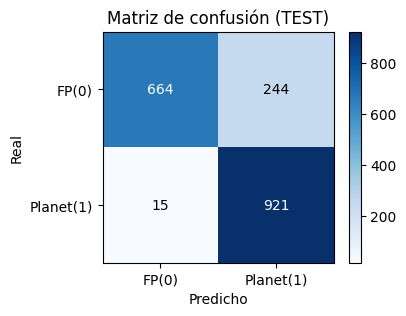

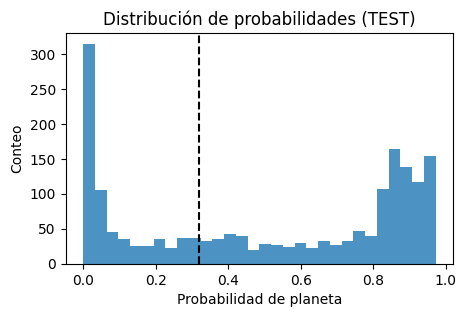


Conteo de veredictos (TEST):


,count
verdict,
Planet(1),1165
FP(0),679


from matplotlib import pyplot as plt
_df_0['count'].plot(kind='hist', bins=20, title='count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['count'].plot(kind='line', figsize=(8, 4), title='count')
plt.gca().spines[['top', 'right']].set_visible(False)

In [7]:
# =========================================
# Demo "vista de la app" en Colab
#   - Carga modelo rf_koi.joblib + final_config.json si existen
#   - Si no, entrena rápidamente para la demo
#   - Predice sobre TEST y muestra tablas/gráficas como vería el usuario
# =========================================
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from joblib import load
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef,
    confusion_matrix)

# ---------- CONFIG ----------
CSV_IN = "/content/kepler_clean.csv"       # <- tu dataset limpio
MODEL_PATH = Path("/content/rf_koi.joblib")
CFG_PATH   = Path("/content/final_config.json")
RANDOM_STATE = 42
FALLBACK_THR = 0.32        # umbral operativo acordado si no hay config
USE_FPFLAGS  = False

# ---------- carga dataset + derivadas (igual que en entrenamiento) ----------
df = pd.read_csv(CSV_IN)
assert "label" in df.columns, "Falta 'label' en el CSV."
# derivadas por si acaso
if {"koi_period","koi_duration","koi_depth"}.issubset(df.columns):
    with np.errstate(divide="ignore", invalid="ignore"):
        df["duty_cycle"] = df["koi_duration"] / (df["koi_period"] * 24.0)
if "koi_depth" in df.columns:
    df["depth_frac"]  = (df["koi_depth"].clip(lower=1e-9)) * 1e-6
    df["rprstar_est"] = np.sqrt(df["depth_frac"])
if "koi_period" in df.columns:
    df["log_period"] = np.log10(df["koi_period"].clip(lower=1e-9))
if "koi_depth" in df.columns:
    df["log_depth"] = np.log10(df["koi_depth"].clip(lower=1e-9))

# columnas meta para mostrar en tablas
meta_cols = [c for c in ["object_id","kepoi_name","kepler_name","kepid","koi_disposition"] if c in df.columns]

# features
ban = {"label","object_id","kepoi_name","kepler_name","koi_name","kepid","source","koi_disposition"}
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in num_cols if c not in ban]
if not USE_FPFLAGS:
    features = [c for c in features if not c.startswith("koi_fpflag_")]

X_all = df[features].copy().values
y_all = df["label"].astype(int).values

print(f"Filas={len(df)} | Features={len(features)} | %Pos={100*y_all.mean():.1f}%")
print("Features clave:", [f for f in features if f in ["koi_period","koi_duration","koi_depth","koi_model_snr","duty_cycle","koi_prad","koi_impact"]])

# ---------- carga modelo o entrena si no existe ----------
if MODEL_PATH.exists() and CFG_PATH.exists():
    rf = load(MODEL_PATH)
    cfg = json.load(open(CFG_PATH, "r"))
    THR = float(cfg.get("threshold", FALLBACK_THR))
    # si el config trae features, respétalos (supone que están en df)
    if "features" in cfg:
        features = cfg["features"]
        X_all = df[features].copy().values
    print(f"Modelo cargado ✅  | Umbral={THR}")
else:
    print("No se encontró rf_koi.joblib → entreno rápido para la demo…")
    rf = RandomForestClassifier(
        n_estimators=500, max_depth=12, min_samples_leaf=5,
        max_features="sqrt", random_state=RANDOM_STATE, n_jobs=-1
    )
    rf.fit(X_all, y_all)
    THR = FALLBACK_THR
    print(f"Modelo entrenado (demo) ✅  | Umbral={THR}")

# ---------- split 60/20/20 para DEMO ----------
X_tmp, X_test, y_tmp, y_test, idx_tmp, idx_test = train_test_split(
    X_all, y_all, np.arange(len(df)), test_size=0.20, random_state=RANDOM_STATE, stratify=y_all
)
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_tmp, y_tmp, idx_tmp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_tmp
) # 60/20/20

# ---------- predicción en TEST ----------
p_test = rf.predict_proba(X_test)[:,1]
y_pred = (p_test >= THR).astype(int)

# métricas globales test (para el header de la app)
def metrics(y, p, thr):
    yhat = (p >= thr).astype(int)
    return dict(
        ROC_AUC=roc_auc_score(y,p), PR_AUC=average_precision_score(y,p),
        Accuracy=accuracy_score(y,yhat), Precision=precision_score(y,yhat),
        Recall=recall_score(y,yhat), F1=f1_score(y,yhat), MCC=matthews_corrcoef(y,yhat),
        CM=confusion_matrix(y,yhat)
    )
m = metrics(y_test, p_test, THR)
print("\n=== Métricas TEST (umbral app) ===")
for k in ["ROC_AUC","PR_AUC","Accuracy","Precision","Recall","F1","MCC"]:
    print(f"{k}: {m[k]:.3f}")
print("Confusion matrix [[TN FP],[FN TP]]:\n", m["CM"])

# ---------- “Vista app”: tablas con ejemplos ----------
test_df = df.iloc[idx_test].copy()
test_df["probability"] = p_test
test_df["pred_label"] = y_pred
test_df["true_label"] = y_test
test_df["verdict"] = np.where(test_df["pred_label"]==1,"Planet(1)","FP(0)")
test_df["true_txt"] = np.where(test_df["true_label"]==1,"Planet(1)","FP(0)")

cols_show = meta_cols + ["probability","verdict","true_txt","koi_period","koi_duration","koi_depth","koi_model_snr","duty_cycle","koi_prad","koi_impact"]
cols_show = [c for c in cols_show if c in test_df.columns]

# 1) Top-10 candidatos por probabilidad
top_pos = (test_df.sort_values("probability", ascending=False)
                  .head(10)[cols_show])
print("\nTop 10 candidatos (probabilidad más alta):")
display(top_pos.style.bar(subset=["probability"], color="#4CAF50"))

# 2) Top-10 no-planetas (probabilidad más baja)
top_neg = (test_df.sort_values("probability", ascending=True)
                  .head(10)[cols_show])
print("\nTop 10 no-planetas (probabilidad más baja):")
display(top_neg.style.bar(subset=["probability"], color="#f44336"))

# 3) Errores interesantes: Falsos positivos y falsos negativos (hasta 10)
fp = test_df[(test_df["pred_label"]==1) & (test_df["true_label"]==0)].sort_values("probability", ascending=False).head(10)[cols_show]
fn = test_df[(test_df["pred_label"]==0) & (test_df["true_label"]==1)].sort_values("probability", ascending=True).head(10)[cols_show]
print("\nFalsos positivos (pred=1, real=0):")
display(fp.style.bar(subset=["probability"], color="#FFC107"))
print("\nFalsos negativos (pred=0, real=1):")
display(fn.style.bar(subset=["probability"], color="#FFC107"))

# ---------- Gráficas ligeras (como mostraría la app) ----------
# 1) Matriz de confusión
cm = m["CM"]
fig, ax = plt.subplots(figsize=(4,3))
im = ax.imshow(cm, cmap="Blues")
fig.colorbar(im, ax=ax)
ax.set_xticks([0,1]); ax.set_xticklabels(["FP(0)","Planet(1)"])
ax.set_yticks([0,1]); ax.set_yticklabels(["FP(0)","Planet(1)"])
ax.set_xlabel("Predicho"); ax.set_ylabel("Real")
ax.set_title("Matriz de confusión (TEST)")
for i in range(2):
    for j in range(2):
        ax.text(j,i,cm[i,j],ha="center",va="center", color="white" if cm[i,j]>cm.max()/2 else "black")
plt.show()

# 2) Histograma de probabilidades (TEST)
fig, ax = plt.subplots(figsize=(5,3))
ax.hist(test_df["probability"], bins=30, alpha=0.8)
ax.axvline(THR, ls="--", color="k")
ax.set_xlabel("Probabilidad de planeta")
ax.set_ylabel("Conteo")
ax.set_title("Distribución de probabilidades (TEST)")
plt.show()

# 3) Conteo de veredictos en TEST
vc = test_df["verdict"].value_counts().reindex(["Planet(1)","FP(0)"]).fillna(0).astype(int)
print("\nConteo de veredictos (TEST):")
display(vc.to_frame("count"))
